# Notebook 6a: Time-Dependent Advection-Diffusion

This notebook introduces time-dependent problems in Underworld3 through the advection-diffusion equation. We'll test the numerical solution against analytical solutions for the advection and diffusion of temperature steps.

## Key Concepts

1. **Time-stepping** - Explicit time integration for advection-diffusion
2. **CFL condition** - Stability constraints on time step size
3. **Analytical validation** - Comparing with known solutions
4. **Advection vs Diffusion** - Understanding the balance between transport mechanisms

## The Advection-Diffusion Equation

We solve:
$$\frac{\partial T}{\partial t} + \mathbf{u} \cdot \nabla T = \kappa \nabla^2 T$$

where:
- $T$ is temperature (or any scalar field)
- $\mathbf{u}$ is the velocity field
- $\kappa$ is the diffusivity

In [1]:
#| echo: false
# Fix pyvista for interactive notebooks
import nest_asyncio
nest_asyncio.apply()

In [2]:
#| output: false
import numpy as np
import sympy
import underworld3 as uw
import matplotlib.pyplot as plt

## Problem Setup

We'll simulate a temperature step function being advected from left to right by a constant velocity while simultaneously diffusing. 
This is a classic test problem with a simple analytical solution and is particularly good at showing how well the advection scheme
operates. 

In [3]:
# Model parameters
res = 10  # Resolution parameter
velocity_magnitude = 10.0  # Advection velocity (horizontal)
kappa_value = 0.1  # Thermal diffusivity
t_start = 0.01  # Start time (step already diffused at this time)
initial_step_position = -0.33  # Position where step center is at t_start
final_step_position = 0.33  # Target position for step center
t_end = t_start + (final_step_position - initial_step_position) / velocity_magnitude

# Create mesh
mesh = uw.meshing.UnstructuredSimplexBox(
    minCoords=(-1.0, 0.0),
    maxCoords=(+1.0, 1.0),
    cellSize=1 / res,
    regular=False,
    qdegree=3,
)

# Coordinate system
x, y = mesh.CoordinateSystem.X

print(f"Peclet number (advection/diffusion): {velocity_magnitude * 2.0 / kappa_value:.1f}")

Peclet number (advection/diffusion): 200.0


## Analytical Solutions

For a step function initially at $x = x_0$, advected with velocity $u$ and diffusing with diffusivity $\kappa$:

$$T(x,t) = \frac{1}{2}\left[1 + \text{erf}\left(\frac{x - x_0 - ut}{2\sqrt{\kappa t}}\right)\right]$$

This solution represents the classic diffusion of a step function with superimposed advection.

In [4]:
# Define symbolic variables for analytical solution
u, t, x_sym, x0, k = sympy.symbols("u, t, x, x0, k")

# Analytical solution for advected step function
# For a step that was infinitely sharp at t=0, x=x0_original and has been advecting/diffusing since
# At time t, the center is at x0_original + u*t
T_analytical_step = (1 + sympy.erf((x_sym - x0 - u*t) / (2 * sympy.sqrt(k * t)))) / 2

# The original step position at t=0 (before any advection)
x0_original = initial_step_position - velocity_magnitude * t_start

# At t_start, the step center is at initial_step_position
T_initial = T_analytical_step.subs({
    u: velocity_magnitude, 
    t: t_start, 
    x_sym: x,
    x0: x0_original,  # Original position at t=0
    k: kappa_value
})

# At t_end, the step center should be at final_step_position
T_final = T_analytical_step.subs({
    u: velocity_magnitude, 
    t: t_end, 
    x_sym: x, 
    x0: x0_original,  # Same original position
    k: kappa_value
})

# Evaluate boundary values
left_bc, right_bc = uw.function.evaluate(T_initial, np.array(((-1.0, 0.0), (1.0, 0.0)))).squeeze()
print(f"Original step position at t=0: x = {x0_original:.3f}")
print(f"Step center at t={t_start}: x = {x0_original + velocity_magnitude * t_start:.3f} (should be {initial_step_position:.2f})")
print(f"Step center at t={t_end:.3f}: x = {x0_original + velocity_magnitude * t_end:.3f} (should be {final_step_position:.2f})")
print(f"Boundary conditions: Left = {left_bc:.3f}, Right = {right_bc:.3f}")

Original step position at t=0: x = -0.430
Step center at t=0.01: x = -0.330 (should be -0.33)
Step center at t=0.076: x = 0.330 (should be 0.33)
Boundary conditions: Left = 0.000, Right = 1.000


## Create Variables and Solver

We need:
- Temperature field `T` (what we're solving for)
- Velocity field `v` (prescribed advection velocity)
- Reference fields for comparison

In [5]:
# Create mesh variables
T = uw.discretisation.MeshVariable("T", mesh, 1, degree=3)
v = uw.discretisation.MeshVariable("v", mesh, mesh.dim, degree=1)
T_initial_field = uw.discretisation.MeshVariable("T0", mesh, 1, degree=3)

# Create advection-diffusion solver
adv_diff = uw.systems.AdvDiffusion(
    mesh,
    u_Field=T,
    V_fn=v,
    order=2,  # First-order time stepping
)

# Set diffusivity
adv_diff.constitutive_model = uw.constitutive_models.DiffusionModel
adv_diff.constitutive_model.Parameters.diffusivity = kappa_value

# Apply boundary conditions (Dirichlet on left and right)
adv_diff.add_dirichlet_bc(left_bc, "Left")
adv_diff.add_dirichlet_bc(right_bc, "Right")

# Set velocity field (uniform horizontal flow)
with uw.synchronised_array_update():
    v.array[:, :, 0] = velocity_magnitude  # x-component
    v.array[:, :, 1] = 0.0  # y-component

print(f"Advection-Diffusion solver created with diffusivity = {kappa_value}")

Advection-Diffusion solver created with diffusivity = 0.1


In [6]:
adv_diff.view()

**Class**: <class 'underworld3.systems.solvers.SNES_AdvectionDiffusion'>

# Underworld / PETSc General Scalar Equation Solver

Primary problem: 

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

*Where:*

# Details

# Details

# Boundary Conditions

| Type   | Boundary | Expression | 
|:------------------------ | -------- | ---------- | 
| **essential** | Left | $\left[\begin{matrix}0.0\end{matrix}\right]  $ | 
| **essential** | Right | $\left[\begin{matrix}1.0\end{matrix}\right]  $ | 


This solver is formulated as a 2 dimensional problem with a 2 dimensional mesh

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Set Initial Conditions

We initialize the temperature field with the analytical solution at $t = t_{start}$.

In [7]:
uw.get_units(T)

In [8]:
# Set initial temperature distribution
T.array[...] = uw.function.evaluate(T_initial, T.coords)
T_initial_field.array[...] = T.array[...]  # Store for comparison

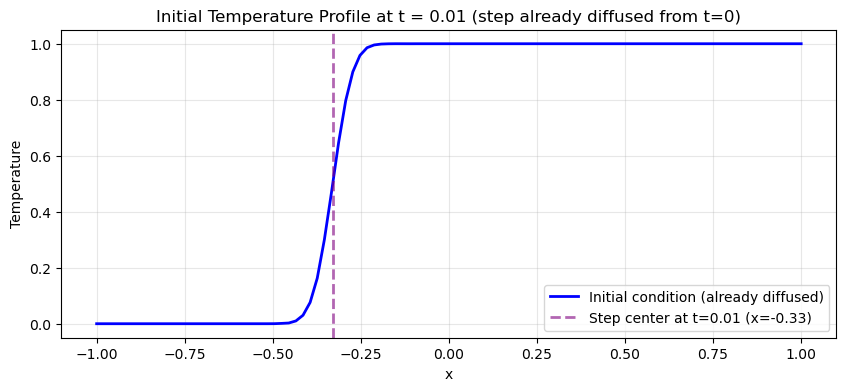

In [9]:
# Visualize initial condition
fig, ax = plt.subplots(figsize=(10, 4))

# Sample along horizontal line
sample_x = np.linspace(-1, 1, 100)
sample_y = np.zeros_like(sample_x) + 0.5
sample_points = np.column_stack([sample_x, sample_y])

T_profile = uw.function.evaluate(T.sym, sample_points).squeeze()

ax.plot(sample_x, T_profile, 'b-', linewidth=2, label='Initial condition (already diffused)')
ax.axvline(x=initial_step_position, color='purple', linestyle='--', 
           alpha=0.6, linewidth=2, label=f'Step center at t={t_start} (x={initial_step_position:.2f})')
ax.set_xlabel('x')
ax.set_ylabel('Temperature')
ax.set_title(f'Initial Temperature Profile at t = {t_start} (step already diffused from t=0)')
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

## Time Stepping

In many time-stepping schemes, the time step is constrained by the CFL (Courant-Friedricks-Levy) condition for stability. In the case of the 
Semi-Lagrange advection scheme which is used by default by `uw.systems.AdvDiffusion`, the method is implicit and
should work for large timesteps. However, there remains the concept of an element-crossing time that is fundamental
in understanding how numerical timestepping operates.

The classic CFL condition for stability relates timestep to the propagation of information from one mesh point to the
next whether by diffusion or advection.

- Advection CFL: $\Delta t < \Delta x / |u|$
- Diffusion CFL: $\Delta t < \Delta x^2 / (2\kappa)$

In an unconditionally stable scheme, the element crossing time still tells us whether our choice of timestep is a reasonable one. If we take 
very tiny steps compared to the element crossing time, then we may expose ourselves to small, cumulative interpolation errors. If we take very
large timesteps, we may simply have poor temporal resolution (we are not resolving processes that operate on short timescales).

The solver estimates an appropriate time step based on the element-crossing times but you can treat these as a guideline, particularly if the mesh
resolution is very variable.

In [10]:
# Estimate required number of time steps
dt_estimate = adv_diff.estimate_dt()
n_steps = max(1, int((t_end - t_start) / (2 * dt_estimate)))
dt = (t_end - t_start) / n_steps

print(f"Estimated dt for stability: {dt_estimate:.5f}")
print(f"Using dt = {dt:.5f}")
print(f"Number of time steps: {n_steps}")
print(f"\nTime stepping from t = {t_start} to t = {t_end}")
print("-" * 40)

# Time stepping loop
model_time = t_start
time_history = [model_time]

for step in range(n_steps):
    # Solve for one time step
    adv_diff.solve(timestep=dt)
    model_time += dt
    time_history.append(model_time)
    
    if step % max(1, n_steps // 5) == 0 or step == n_steps - 1:
        print(f"Step {step+1:3d}/{n_steps}: t = {model_time:.4f}")

print("-" * 40)
print(f"Time stepping complete")

Estimated dt for stability: 0.00437
Using dt = 0.00943
Number of time steps: 7

Time stepping from t = 0.01 to t = 0.076
----------------------------------------
Step   1/7: t = 0.0194
Step   2/7: t = 0.0289
Step   3/7: t = 0.0383
Step   4/7: t = 0.0477
Step   5/7: t = 0.0571
Step   6/7: t = 0.0666
Step   7/7: t = 0.0760
----------------------------------------
Time stepping complete


L2 Error: 5.3817e-04
Max Error: 1.5581e-03


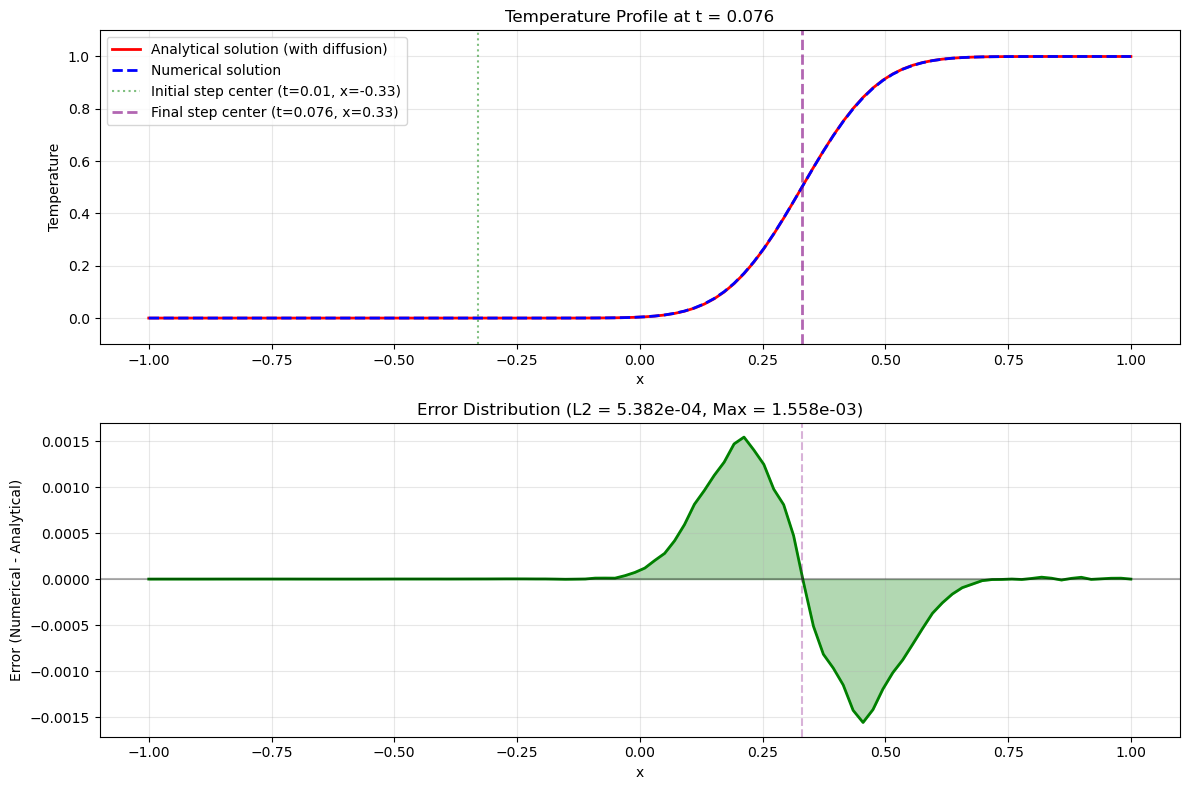

In [11]:
# Sample solutions along horizontal line
T_numerical = uw.function.evaluate(T.sym, sample_points).squeeze()
T_analytical = uw.function.evaluate(T_final, sample_points).squeeze()

# Calculate error metrics
error = T_numerical - T_analytical
L2_error = np.sqrt(np.mean(error**2))
max_error = np.max(np.abs(error))

print(f"L2 Error: {L2_error:.4e}")
print(f"Max Error: {max_error:.4e}")

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Top plot: Solutions comparison
ax1 = axes[0]
ax1.plot(sample_x, T_analytical, 'r-', linewidth=2, label='Analytical solution (with diffusion)')
ax1.plot(sample_x, T_numerical, 'b--', linewidth=2, label='Numerical solution')

# Show initial step position
ax1.axvline(x=initial_step_position, color='green', 
           linestyle=':', alpha=0.5, linewidth=1.5, label=f'Initial step center (t={t_start}, x={initial_step_position:.2f})')

# Show final step position (where center should be after advection)
ax1.axvline(x=final_step_position, color='purple', linestyle='--', alpha=0.6, linewidth=2,
           label=f'Final step center (t={t_end:.3f}, x={final_step_position:.2f})')

ax1.set_xlabel('x')
ax1.set_ylabel('Temperature')
ax1.set_title(f'Temperature Profile at t = {t_end:.3f}')
ax1.grid(True, alpha=0.3)
ax1.legend(loc='best')
ax1.set_ylim(-0.1, 1.1)

# Bottom plot: Error distribution
ax2 = axes[1]
ax2.plot(sample_x, error, 'g-', linewidth=2)
ax2.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax2.fill_between(sample_x, 0, error, alpha=0.3, color='green')
ax2.axvline(x=final_step_position, color='purple', linestyle='--', alpha=0.3, linewidth=1.5)
ax2.set_xlabel('x')
ax2.set_ylabel('Error (Numerical - Analytical)')
ax2.set_title(f'Error Distribution (L2 = {L2_error:.3e}, Max = {max_error:.3e})')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("media/advection_diffusion_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

## Visualize 2D Solution Field

Let's create an interactive visualization of the full 2D temperature field.

In [12]:
if uw.mpi.size == 1:
    import pyvista as pv
    import underworld3.visualisation as vis

    # Create pyvista mesh
    pvmesh = vis.mesh_to_pv_mesh(mesh)
    pvmesh.point_data["T_numerical"] = vis.scalar_fn_to_pv_points(pvmesh, T.sym)
    pvmesh.point_data["T_analytical"] = vis.scalar_fn_to_pv_points(pvmesh, T_final)
    pvmesh.point_data["T_initial"] = vis.scalar_fn_to_pv_points(pvmesh, T_initial_field.sym)
    pvmesh.point_data["Error"] = pvmesh.point_data["T_numerical"] - pvmesh.point_data["T_analytical"]

    # Create visualization
    pl = pv.Plotter(window_size=(1200, 600), shape=(1, 2))

    # Left: Temperature field
    pl.subplot(0, 0)
    pl.add_mesh(
        pvmesh,
        scalars="T_numerical",
        cmap="RdBu_r",
        edge_color="Grey",
        show_edges=True,
        edge_opacity=0.2,
        scalar_bar_args=dict(title="Temperature")
    )
    pl.add_text("Numerical Solution", position='upper_edge', font_size=10)

    # Right: Error field
    pl.subplot(0, 1)
    pl.add_mesh(
        pvmesh,
        scalars="Error",
        cmap="seismic",
        edge_color="Grey",
        show_edges=True,
        edge_opacity=0.2,
        scalar_bar_args=dict(title="Error"),
        clim=[-max_error, max_error]
    )
    pl.add_text("Error Distribution", position='upper_edge', font_size=10)

    pl.export_html("html5/advection_test.html")

    
    print(f"Maximum error in domain: {np.abs(pvmesh.point_data['Error']).max():.4e}")

Maximum error in domain: 2.2786e-02


In [13]:
#| fig-cap: "Interactive visualization of the advection-diffusion solution and error field"
from IPython.display import IFrame
IFrame(src="html5/advection_test.html", width=800, height=400)

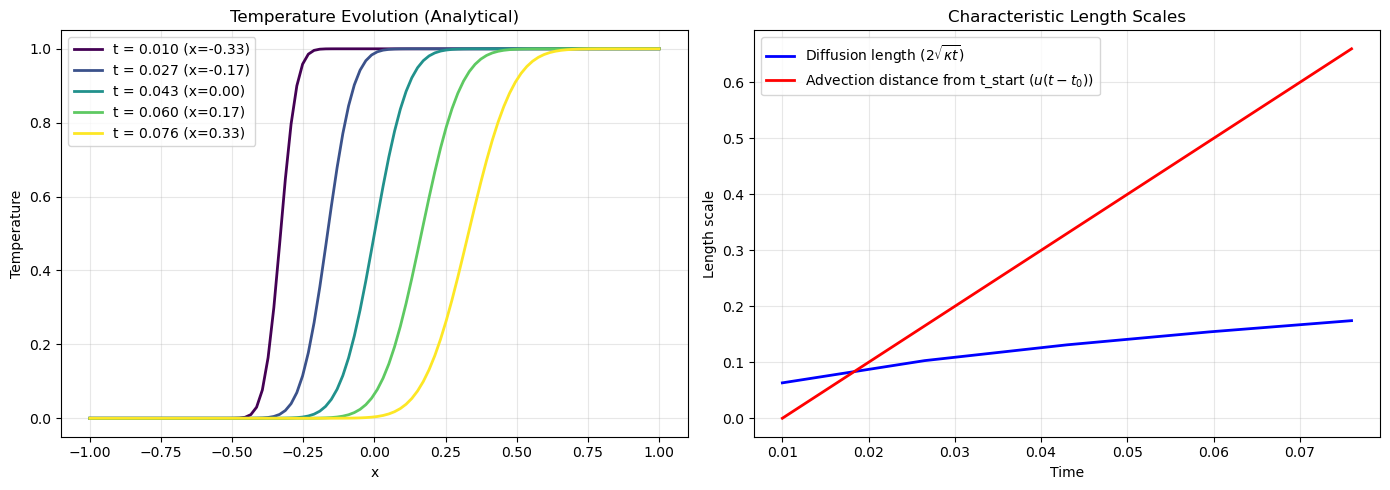


Peclet number: 200.0
During simulation (t=0.01 to t=0.076):
  - Step advects 0.66 units (from x=-0.33 to x=0.33)
  - Diffusion length at t_end: 0.174 units
  - Total diffusion since t=0: 0.174 units


In [14]:
# Evolution at different times
times = np.linspace(t_start, t_end, 5)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Temperature profiles at different times
ax1 = axes[0]
colors = plt.cm.viridis(np.linspace(0, 1, len(times)))

for i, t_val in enumerate(times):
    T_at_t = T_analytical_step.subs({
        u: velocity_magnitude, 
        t: t_val, 
        x_sym: x, 
        x0: x0_original,  # Use the original position
        k: kappa_value
    })
    T_profile_t = uw.function.evaluate(T_at_t, sample_points, rbf=True).squeeze()
    step_center = x0_original + velocity_magnitude * t_val
    ax1.plot(sample_x, T_profile_t, color=colors[i], linewidth=2, 
            label=f't = {t_val:.3f} (x={step_center:.2f})')

ax1.set_xlabel('x')
ax1.set_ylabel('Temperature')
ax1.set_title('Temperature Evolution (Analytical)')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Right plot: Characteristic widths
ax2 = axes[1]
diffusion_lengths = 2 * np.sqrt(kappa_value * times)
advection_distances = velocity_magnitude * (times - t_start)  # Distance from initial position

ax2.plot(times, diffusion_lengths, 'b-', linewidth=2, label='Diffusion length ($2\\sqrt{\\kappa t}$)')
ax2.plot(times, advection_distances, 'r-', linewidth=2, label='Advection distance from t_start ($u(t-t_0)$)')
ax2.set_xlabel('Time')
ax2.set_ylabel('Length scale')
ax2.set_title('Characteristic Length Scales')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig("media/advection_diffusion_analysis.png", dpi=150, bbox_inches='tight')
plt.show()

Pe = velocity_magnitude * 2.0 / kappa_value
print(f"\nPeclet number: {Pe:.1f}")
print(f"During simulation (t={t_start} to t={t_end:.3f}):")
print(f"  - Step advects {final_step_position - initial_step_position:.2f} units (from x={initial_step_position:.2f} to x={final_step_position:.2f})")
print(f"  - Diffusion length at t_end: {2 * np.sqrt(kappa_value * t_end):.3f} units")
print(f"  - Total diffusion since t=0: {2 * np.sqrt(kappa_value * t_end):.3f} units")

## Key Takeaways

- Higher Peclet numbers require finer meshes to resolve sharp fronts
- The solver handles mixed advection-diffusion regimes well
- Boundary conditions must be consistent with the analytical solution

## Exercise 6a.1

Try varying the parameters:
1. Increase velocity to 50 - what happens to the solution quality?
2. Decrease diffusivity to 0.01 - how does this affect the time stepping?
3. Change the mesh resolution - how does error scale with mesh size?

## Exercise 6a.2

Implement a "top hat" initial condition (step up at x=-0.5, step down at x=0.5):

$$T(x,t) = \frac{1}{2}\left[\text{erf}\left(\frac{x + 0.5 - ut}{2\sqrt{\kappa t}}\right) - \text{erf}\left(\frac{x - 0.5 - ut}{2\sqrt{\kappa t}}\right)\right]$$

How well does the numerical solution preserve the shape?